In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import sys
import requests
import logging
import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [62]:
# Set Display Width Longer
pd.options.display.max_colwidth = 200  # 100 for long width

# create folder logs/forecast.log if not exist
if not os.path.exists("logs"):
    os.makedirs("logs")

# Set Logging
logging.basicConfig(
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[logging.FileHandler("logs/forecast.log"), logging.StreamHandler()],
)
logging.info("="*40)
logging.info("BEGIN PYTHON FORECAST PROGRAM FOR SPAREPARTS")

2025-02-05 10:13:46 - INFO - ========================================
2025-02-05 10:13:46 - INFO - BEGIN PYTHON FORECAST PROGRAM FOR SPAREPARTS


In [63]:
# Retrive data from API
logging.info('BEGIN Retrieving API')

max_retries=8
delay=2

# Initialize Start and End Date
start_date = (datetime.today().replace(day=1) - relativedelta(months=16)).strftime("%Y-%m-%d") 
end_date = (datetime.today().replace(day=1) - relativedelta(months=1)).strftime("%Y-%m-%d")  

logging.info(f"API Data From Start Date: {start_date} to End Date: {end_date}")

params = {
    "start-date": "2023-07-01",
    "end-date": "2024-10-01",
    "exclude-older": "2023-07-01",
    "branch": "",
    "agency": "",
    "partno": ""
}

url = "http://172.16.5.6:8080/main/web/gdmdcall"
    
for attempt in range(1, max_retries + 1):
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if 'data' in data and 'data-count' in data:
            logging.info(str(data['month-count']) + " Month Data Retrived")
            logging.info(str(data['data-count']) + " Data retrived from API")
            df = pd.DataFrame(data['data'])
            break
        else:
            logging.info("Error: Unexpected API response format")
            break
    except requests.RequestException as e:
        logging.info(f"Attempt {attempt}: API request failed - {e}")
        if attempt < max_retries:
            time.sleep(delay * (2 ** (attempt - 1)))  # Exponential backoff
        else:
            logging.info("Max retries reached. Exiting.")
            sys.exit(1)

# display(df.head())

2025-02-05 10:13:46 - INFO - BEGIN Retrieving API
2025-02-05 10:13:46 - INFO - API Data From Start Date: 2023-10-01 to End Date: 2025-01-01
2025-02-05 10:13:48 - INFO - 16 Month Data Retrived
2025-02-05 10:13:48 - INFO - 1468 Data retrived from API


In [64]:
# Contruct All Branch Data and Concat It To DF
logging.info("BEGIN Constructing All Branch Data and Combine It to DF")

df_all = df.groupby(["agency", "partno"], as_index=False)["d"].apply(
    lambda x: np.sum(np.array(x.tolist()), axis=0).tolist()
)
df_all.insert(0, "branch", "ALL")
df = pd.concat([df, df_all], ignore_index=True)

logging.info(
    f"All Branch Data Constructed And Merged With DF With Total Data {len(df)}"
)

2025-02-05 10:13:48 - INFO - BEGIN Constructing All Branch Data and Combine It to DF
2025-02-05 10:13:48 - INFO - All Branch Data Constructed And Merged With DF With Total Data 2914


In [65]:
# Calculate Forecast
logging.info("BEGIN Forecast Calculation")
# display(df)

2025-02-05 10:13:48 - INFO - BEGIN Forecast Calculation


In [66]:
logging.info("BEGIN Mean, Std, UB Calculation, and Construct Clipping Data")

# Get mean and standard deviation of 12 periods before the last one
df['mean_12'] = df['d'].apply(lambda x: np.mean(x[-13:-1]))  # Use 12 periods before the last one
df['std_12'] = df['d'].apply(lambda x: np.std(x[-13:-1]))    # Use 12 periods before the last one

# Get upper bound from mean and std
df['ub'] = df['mean_12'] + 1.5 * df['std_12']

# Limit the original df to upper bound (using the 12 periods before the last one)
df['clipped_d'] = df.apply(lambda row: np.clip(row['d'][-13:-1], 0, row['ub']).tolist(), axis=1)

# Display the updated DataFrame
# display(df.head())

2025-02-05 10:13:48 - INFO - BEGIN Mean, Std, UB Calculation, and Construct Clipping Data


In [67]:
logging.info("BEGIN Simple Moving Average Calculation")

# Calculate Simple Moving Average
df['ma'] = df['clipped_d'].apply(lambda x: pd.Series(x).rolling(window=len(x), min_periods=1).mean().tolist())
df['ma_result'] = df['ma'].apply(lambda x: x[-1:])

# Display the updated DataFrame
# display(df.head())

2025-02-05 10:13:48 - INFO - BEGIN Simple Moving Average Calculation


In [68]:
logging.info("BEGIN Weighted Moving Average Calculation")

df['wma_clipped_d'] = df.apply(lambda row: np.clip(row['d'][-16:-1], 0, row['ub']).tolist(), axis=1)

def wma_forecast_with_weights(df, weights):
    wma_values = [None] * 3
    for i in range(3, len(df)):
        forecast = np.sum(np.array(df[i-3:i]) * weights) / sum(weights)
        wma_values.append(forecast)
    return wma_values

def generate_weights(step=0.05):
    weights = []
    for w1 in np.arange(0.15, 1, step):
        for w2 in np.arange(max(0.25, w1 + 0.01), 1 - w1, step):
            w3 = 1 - w1 - w2
            if w3 > w2 > w1:
                weights.append((w1, w2, w3))
    return weights

best_weights_list = []
best_maes = []

for row in df['wma_clipped_d']:
    best_mae = float('inf')
    best_weights = None
    for weights in generate_weights(step=0.05):
        wma_values = wma_forecast_with_weights(row, weights)
        mae = mean_absolute_error(row[-12:], wma_values[-12:])
        if mae < best_mae:
            best_mae = mae
            best_weights = weights
    best_weights_list.append(best_weights)
    best_maes.append(best_mae)

df['best_weights'] = best_weights_list
df['best_mae'] = best_maes

df['wma'], df['wma_result'] = zip(*df.apply(lambda row: (
    wma_forecast_with_weights(row['wma_clipped_d'], row['best_weights'])[3:][-12:],
    wma_forecast_with_weights(row['wma_clipped_d'], row['best_weights'])[-1:]
), axis=1))

# display(df)

2025-02-05 10:13:48 - INFO - BEGIN Weighted Moving Average Calculation


In [69]:
logging.info("BEGIN Exponential Weighted Moving Average Calculation")

# Calculate Exponential Weighted Moving Average (EWMA)
alpha_ewma = 0.4

def ewma(list, alpha = alpha_ewma):
    df = pd.DataFrame(list)
    df['ewma'] = df.ewm(alpha=alpha_ewma, adjust=False).mean()
    return df['ewma'].tolist()

def ewma_forecast(list, alpha):
    ewma_values = ewma(list, alpha)
    if len(ewma_values) > 0:
        # Prediction for the next period
        next_forecast = (1 - alpha) * ewma_values[-1]
    else:
        next_forecast = None
    return ewma_values, next_forecast

df['ewma'], df['ewma_result'] = zip(*df['clipped_d'].apply(lambda x: ewma_forecast(x, alpha_ewma)))

# display(df)

2025-02-05 10:13:55 - INFO - BEGIN Exponential Weighted Moving Average Calculation


In [70]:
logging.info("BEGIN Linear Reggression Calculation")

#LINEAR REGRESSION
#  Calculate Linear Regression
def lr(x):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    model =  LinearRegression()
    model.fit(df[['x']], df['y'])
    df.loc[len(df), 'x'] = len(df) + 1
    return model.predict(df[['x']])

df['lr'] = df['clipped_d'].apply(lambda x: lr(x))
df['lr_result'] = df['lr'].apply(lambda x: x[-1:])
# display(df)

2025-02-05 10:13:55 - INFO - BEGIN Linear Reggression Calculation


In [126]:
logging.info("BEGIN Polynomial Regression Calculation")

# POLYNOMIAL 2ND AND 3RD
# Calculate Polynomial Regression
def pr(x, pr_degree):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)  # D-13 to D-1 mapped as x=1 to x=13

    X = df[['x']]  # Independent variable
    y = df['y']    # Dependent variable

    poly = PolynomialFeatures(degree=pr_degree)  # Create polynomial features
    X_poly = poly.fit_transform(X)  # Transform input features
    poly_model = LinearRegression()  # Initialize linear regression model
    poly_model.fit(X_poly, y)  # Fit polynomial model

    # Predict for D-13 to D-2
    df.loc[len(df), 'x'] = len(df) + 1  # Add one more row for D-1 prediction
    X_all_poly = poly.transform(df[['x']])
    predictions = poly_model.predict(X_all_poly)  

    return predictions[:-1], predictions[-1]  # Return D-13 to D-2 and D-1 separately

# Apply polynomial regression to each row
df[['pr2', 'pr2_result']] = df['clipped_d'].apply(lambda x: pd.Series(pr(x, 2)))
df[['pr3', 'pr3_result']] = df['clipped_d'].apply(lambda x: pd.Series(pr(x, 3)))

2025-02-05 13:17:10 - INFO - BEGIN Polynomial Regression Calculation


     branch agency               partno  \
0        21     06             51629287   
1        21     06           5802721728   
2        21     08             47364493   
3        21     08             47364908   
4        21     08             47535939   
...     ...    ...                  ...   
2909    ALL     88                  N70   
2910    ALL     88           RISH EINE+   
2911    ALL     88  RISH EINE+ 25A/75MV   
2912    ALL     88    RISH EINE+ 500VDC   
2913    ALL     88               S6700H   

                                                     d   mean_12    std_12  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
2     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.000000  0.000000   
3     [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.000000  0.000000   
...            

In [130]:
logging.info("BEGIN Simple Exponential Smoothing Calculation")

alpha_ses = 0.65  # ubah nilai alpha (semakin besar semakin berat ke data terbaru)

#SES
def ses(x, alpha=alpha_ses):
    df = pd.DataFrame()
    df['y'] = x  # Use only original 12 values (D-13 to D-2)
    df['x'] = range(1, len(df) + 1)  # Index from 1 to 12

    model = SimpleExpSmoothing(df['y']).fit(smoothing_level=alpha, optimized=False)
    fitted_values = model.fittedvalues.tolist()  # This will now return only 12 values

    return fitted_values

df['ses'] = df['clipped_d'].apply(lambda x: ses(x, alpha_ses))
df['ses_result'] = df['ses'].apply(lambda x: x[-1])  # Extract last value for D-2
print(df)

2025-02-05 13:23:31 - INFO - BEGIN Simple Exponential Smoothing Calculation
c:\Users\Brandon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\Users\Brandon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\Users\Brandon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1412: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\Users\Brandon\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:1419: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\Users\Bra

     branch agency               partno  \
0        21     06             51629287   
1        21     06           5802721728   
2        21     08             47364493   
3        21     08             47364908   
4        21     08             47535939   
...     ...    ...                  ...   
2909    ALL     88                  N70   
2910    ALL     88           RISH EINE+   
2911    ALL     88  RISH EINE+ 25A/75MV   
2912    ALL     88    RISH EINE+ 500VDC   
2913    ALL     88               S6700H   

                                                     d   mean_12    std_12  \
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
2     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.000000  0.000000   
3     [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.166667  0.552771   
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.000000  0.000000   
...            

In [73]:
logging.info("BEGIN Double Exponential Smoothing Calculation")

beta_des = 0.45

#DES
def des(x, alpha = alpha_ses, beta = beta_des):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    df.loc[len(df), 'x'] = len(df) + 1

    new_data = ExponentialSmoothing(df['y'], trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False).fittedvalues
    return new_data.tolist()

df['des'] = df['clipped_d'].apply(lambda x: des(x,alpha_ses, beta_des))
df['des_result'] = df['des'].apply(lambda x: x[-1:])
# display(df)

2025-02-05 10:14:21 - INFO - BEGIN Double Exponential Smoothing Calculation


In [74]:
logging.info("BEGIN Metric Calculation")

# Calculate metrics for each model
def metric(x):
    period_length = len(x['clipped_d'])
    df = pd.DataFrame()
    df['period'] = range(1, period_length + 1)
    df['qty'] = x['clipped_d'][:period_length]  # Ground truth values
    df['ma'] = x['ma'][:period_length]
    df['wma'] = x['wma'][:period_length]
    df['ewma'] = x['ewma'][:period_length]
    df['lr'] = x['lr'][:period_length]
    df['pr2'] = x['pr2'][:period_length]
    df['pr3'] = x['pr3'][:period_length]
    df['ses'] = x['ses'][:period_length]
    df['des'] = x['des'][:period_length]

    # Calculate metrics for each model
    result = []
    for model in df.columns[2:]:  # Loop through model columns (ma, ewma, etc.)
        rmse = np.sqrt(mean_squared_error(df['qty'], df[model]))  # Calculate RMSE
        r2 = r2_score(df['qty'], df[model])  # Calculate R²
        mae = mean_absolute_error(df['qty'], df[model])  # Calculate MAE
        result.append({'model': model, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    
    # Convert result to a DataFrame
    metrics_df = pd.DataFrame(result)
    
    # Select the best model (e.g., based on RMSE)
    best_model_row = metrics_df.loc[metrics_df['MAE'].idxmin()]  # Row with the lowest RMSE
    best_model = best_model_row['model']
    
    # Add the best model and metrics to the result
    return {'best_model': best_model, 'metrics': metrics_df.to_dict(orient='records')}

# Apply the metric function
df['metric'] = df.apply(lambda x: metric(x), axis=1)

# Extract the best model and metrics for each row
df['best_model'] = df['metric'].apply(lambda x: x['best_model'])
df['metrics'] = df['metric'].apply(lambda x: x['metrics'])

# Display the DataFrame
# display(df[['wma']])
# display(df[['best_model', 'metrics']])

2025-02-05 10:14:25 - INFO - BEGIN Metric Calculation


In [75]:
logging.info("BEGIN Data Selection Calculation")

# Select the best model for each row
df['mean_12_FD'] = df['d'].apply(lambda x: np.mean(x[-12:]))
df['std_12_FD'] = df['d'].apply(lambda x: np.std(x[-12:]))

df['ub_FD'] = df['mean_12_FD'] + 1.5 * df['std_12_FD']

df['clipped_d_FD'] = df.apply(lambda row: np.clip(row['d'][-12:], 0, row['ub_FD']).tolist(), axis=1)
def apply_best_model_forecast(row):
    best_model = row['best_model']
    
    data = row['d'][-15:] if best_model == 'wma' else row['d'][-12:]
    
    ub = row['ub_FD']
    clipped_data = np.clip(data, 0, ub).tolist()
    
    if best_model == 'ma':
        ma_values = pd.Series(clipped_data).rolling(window=len(clipped_data), min_periods=1).mean().tolist()
        forecast = ma_values[-1]
    elif best_model == 'ewma':
        alpha = 0.4
        weights = np.array([(1 - alpha) ** i for i in range(len(clipped_data))][::-1])
        forecast = np.sum(weights * clipped_data) / np.sum(weights)
    elif best_model == 'wma':
        weights = row['best_weights']  # Use the optimized weights found earlier
        if weights is None:  # If no best weights were found, use fallback
            weights = [0.15, 0.25, 0.6] 
        if len(clipped_data) >= len(weights):  
            forecast = np.sum(np.array(clipped_data[-3:]) * np.array(weights))
        else:
            forecast = np.nan
    elif best_model == 'lr':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 1)
        forecast = coef[0] * len(clipped_data) + coef[1]
    elif best_model == 'pr2':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 2)
        forecast = coef[0] * (len(clipped_data) ** 2) + coef[1] * len(clipped_data) + coef[2]
    elif best_model == 'pr3':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 3)
        forecast = (
            coef[0] * (len(clipped_data) ** 3)
            + coef[1] * (len(clipped_data) ** 2)
            + coef[2] * len(clipped_data)
            + coef[3]
        )
    elif best_model == 'ses':
        model = SimpleExpSmoothing(clipped_data).fit(smoothing_level=0.65, optimized=False)
        forecast = model.forecast(1)[0]
    elif best_model == 'des':
        model = Holt(clipped_data).fit(smoothing_level=0.65, smoothing_slope=0.45, optimized=False)
        forecast = model.forecast(1)[0]
    else:
        forecast = np.nan
    
    return forecast

df['FD_forecast'] = df.apply(apply_best_model_forecast, axis=1)

df['FD_final'] = df['FD_forecast'].apply(np.ceil)

display(df[['best_model', 'FD_forecast', 'FD_final']])
display(df)

2025-02-05 10:14:47 - INFO - BEGIN Data Selection Calculation


,best_model,FD_forecast,FD_final
0,ewma,0.018625,1.0
1,ewma,0.018625,1.0
2,ma,0.000000,0.0
3,pr3,0.000000,0.0
4,ma,0.000000,0.0
...,...,...,...
2909,ma,0.000000,0.0
2910,ewma,0.009312,1.0
2911,ewma,0.009312,1.0
2912,ewma,0.009312,1.0


,branch,agency,partno,d,mean_12,std_12,ub,clipped_d,ma,ma_result,...,des_result,metric,best_model,metrics,mean_12_FD,std_12_FD,ub_FD,clipped_d_FD,FD_forecast,FD_final
0,21,06,51629287,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]",0.166667,0.552771,0.995823,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9958228642555166, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1422604091793595, 0.12447785803193957, 0.11064698491727962, 0.09958228642555166, 0.09052935129595606, 0.08298523868795972]",[0.08298523868795972],...,[-0.07666598633286426],"{'best_model': 'ewma', 'metrics': [{'model': 'ma', 'RMSE': 0.2551641795300701, 'MAE': 0.11348201453623696, 'R2': 0.14050167583520579}, {'model': 'wma', 'RMSE': 0.3325461952153776, 'MAE': 0.1659704...",ewma,"[{'model': 'ma', 'RMSE': 0.2551641795300701, 'MAE': 0.11348201453623696, 'R2': 0.14050167583520579}, {'model': 'wma', 'RMSE': 0.3325461952153776, 'MAE': 0.1659704773759194, 'R2': -0.45985454545454...",0.166667,0.552771,0.995823,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9958228642555166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.018625,1.0
1,21,06,5802721728,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]",0.166667,0.552771,0.995823,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9958228642555166, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1422604091793595, 0.12447785803193957, 0.11064698491727962, 0.09958228642555166, 0.09052935129595606, 0.08298523868795972]",[0.08298523868795972],...,[-0.07666598633286426],"{'best_model': 'ewma', 'metrics': [{'model': 'ma', 'RMSE': 0.2551641795300701, 'MAE': 0.11348201453623696, 'R2': 0.14050167583520579}, {'model': 'wma', 'RMSE': 0.3325461952153776, 'MAE': 0.1659704...",ewma,"[{'model': 'ma', 'RMSE': 0.2551641795300701, 'MAE': 0.11348201453623696, 'R2': 0.14050167583520579}, {'model': 'wma', 'RMSE': 0.3325461952153776, 'MAE': 0.1659704773759194, 'R2': -0.45985454545454...",0.166667,0.552771,0.995823,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9958228642555166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.018625,1.0
2,21,08,47364493,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[0.0],...,[0.0],"{'best_model': 'ma', 'metrics': [{'model': 'ma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': 'wma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': 'ewma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {...",ma,"[{'model': 'ma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': 'wma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': 'ewma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': 'lr', 'RMSE': 0.0, 'MAE...",0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
3,21,08,47364908,"[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.166667,0.552771,0.995823,"[0.9958228642555166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.9958228642555166, 0.4979114321277583, 0.3319409547518389, 0.24895571606387915, 0.1991645728511033, 0.16597047737591944, 0.1422604091793595, 0.12447785803193957, 0.11064698491727962, 0.099582286...",[0.08298523868795972],...,[0.004223492846155074],"{'best_model': 'pr3', 'metrics': [{'model': 'ma', 'RMSE': 0.21607609156895738, 'MAE': 0.17453544014237876, 'R2': 0.38366184899537903}, {'model': 'wma', 'RMSE': 0.3383111856596274, 'MAE': 0.1659704...",pr3,"[{'model': 'ma', 'RMSE': 0.21607609156895738, 'MAE': 0.17453544014237876, 'R2': 0.38366184899537903}, {'model': 'wma', 'RMSE': 0.3383111856596274, 'MAE': 0.1659704773759194, 'R2': -0.5109090909090...",0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.0
4,21,08,47535939,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",[0.0],...,[0.0],"{'best_model': 'ma', 'metrics': [{'model': 'ma', 'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}, {'model': '

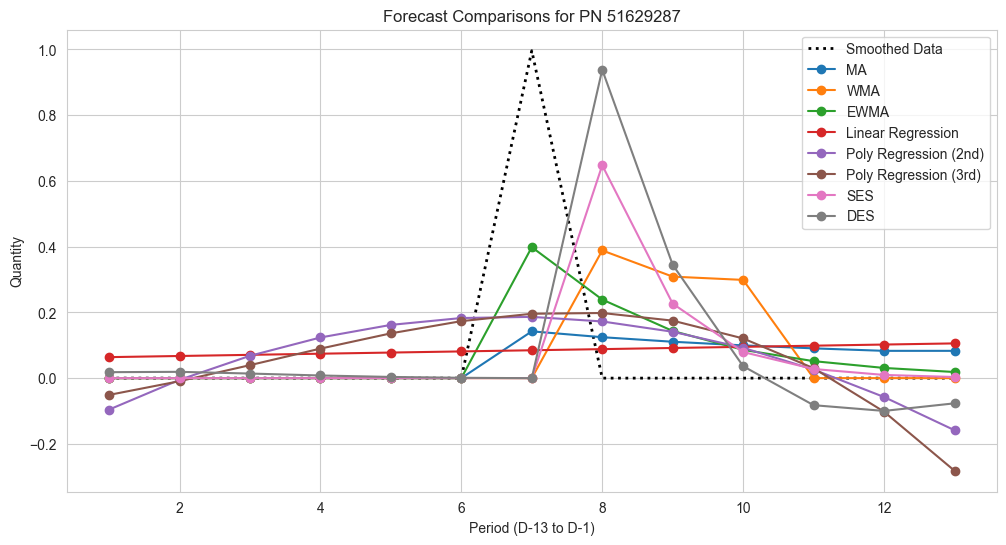

In [114]:
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot multiple models in one figure for a single data point
def plot_all_models(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D_1)

    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D_1)
    plt.plot(x_axis, row['clipped_d'] + [row['clipped_d'][-1]], 
             label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Define models to plot
    models = {
        "MA": ("ma", "ma_result"),
        "WMA": ("wma", "wma_result"),
        "EWMA": ("ewma", "ewma_result"),
        "Linear Regression": ("lr", "lr_result"),
        "Poly Regression (2nd)": ("pr2", "pr2_result"),
        "Poly Regression (3rd)": ("pr3", "pr3_result"),
        "SES": ("ses", "ses_result"),
        "DES": ("des", "des_result")
    }

    for model_name, (col_name, result_col) in models.items():
        # Convert NumPy array to a Python list
        forecast_values = list(row[col_name]) if isinstance(row[col_name], np.ndarray) else row[col_name]
        last_value = row[result_col]  # Get D_1 directly (it's a scalar value)

        # Ensure last_value is a single number, not a list
        if isinstance(last_value, (list, np.ndarray)) and len(last_value) > 0:
            last_value = last_value[0]  # Extract the first element if it's in a list or array

        # Ensure forecast_values is a valid list and last_value is numeric (including zero)
        if isinstance(forecast_values, list) and isinstance(last_value, (int, float)):
            if len(forecast_values) != 12:
                print(f"Warning: {model_name} forecast_values for row {row_idx} has {len(forecast_values)} values instead of 12.")
                forecast_values = forecast_values[:12] + [0] * (12 - len(forecast_values))  # Trim or pad with zeros

            full_forecast = forecast_values + [last_value]  # Merge D_13 to D_2 with D_1
            plt.plot(x_axis, full_forecast, marker='o', label=model_name)
        else:
            print(f"Skipping {model_name} for row {row_idx} due to invalid forecast data.\n")

    plt.title(f"Forecast Comparisons for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot all models for a specific row (change index as needed)
row_idx = 0 # Change this value to plot a different row
plot_all_models(df, row_idx)


In [ ]:
#grafik best
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot multiple models in one figure for a single data point
def plot_all_models(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D_1)

    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D_1)
    plt.plot(x_axis, row['clipped_d'] + [row['clipped_d'][-1]], 
             label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Define models to plot
    models = {
        "MA": ("ma", "ma_result"),
        "WMA": ("wma", "wma_result"),
        "EWMA": ("ewma", "ewma_result"),
        "Linear Regression": ("lr", "lr_result"),
        "Poly Regression (2nd)": ("pr2", "pr2_result"),
        "Poly Regression (3rd)": ("pr3", "pr3_result"),
        "SES": ("ses", "ses_result"),
        "DES": ("des", "des_result")
    }

    for model_name, (col_name, result_col) in models.items():
        # Convert NumPy array to a Python list
        forecast_values = list(row[col_name]) if isinstance(row[col_name], np.ndarray) else row[col_name]
        last_value = row[result_col]  # Get D_1 directly (it's a scalar value)

        # Ensure last_value is a single number, not a list
        if isinstance(last_value, (list, np.ndarray)) and len(last_value) > 0:
            last_value = last_value[0]  # Extract the first element if it's in a list or array

        # Debugging prints
        print(f"Row {row_idx} - {model_name} forecast values: {forecast_values}")
        print(f"Row {row_idx} - {model_name} last value: {last_value}")

        # Ensure forecast_values is a valid list and last_value is numeric (including zero)
        if isinstance(forecast_values, list) and isinstance(last_value, (int, float)):
            if len(forecast_values) != 12:
                print(f"Warning: {model_name} forecast_values for row {row_idx} has {len(forecast_values)} values instead of 12.")
                forecast_values = forecast_values[:12] + [0] * (12 - len(forecast_values))  # Trim or pad with zeros

            full_forecast = forecast_values + [last_value]  # Merge D_13 to D_2 with D_1
            plt.plot(x_axis, full_forecast, marker='o', label=model_name)
        else:
            print(f"Skipping {model_name} for row {row_idx} due to invalid forecast data.\n")

    plt.title(f"Forecast Comparisons for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot all models for a specific row (change index as needed)
row_idx = 0 # Change this value to plot a different row
plot_all_models(df, row_idx)


In [20]:
logging.info("Forecast Calculation Completed")

2025-02-05 08:23:47 - INFO - Forecast Calculation Completed


In [21]:
logging.info("Begin Creating Excel For DataFrame")

# if output folder not exist, create it
if not os.path.exists("output"):
    os.makedirs("output")

# Create Excel File, filename with date
filename = "output/forecast_" + time.strftime("%Y-%m-%d") + ".xlsx"

# Save DataFrame to Excel
df.to_excel(filename, index=False)

# Get the file size in MB
file_size = os.path.getsize(filename) / (1024 * 1024)

logging.info(f"Excel File Created: {filename}, Size: {file_size:.2f} MB")



2025-02-05 08:23:47 - INFO - Begin Creating Excel For DataFrame
2025-02-05 08:23:50 - INFO - Excel File Created: output/forecast_2025-02-05.xlsx, Size: 1.68 MB


In [22]:
# Send Data Back To API
logging.info("BEGIN Constructing Final Data and send it back to API")

url = "http://172.16.5.6:8080/v1/web/test9-post"

# construct result with branch, agency, partno
result = df[['branch', 'agency', 'partno', 'FD_final', 'std_12_FD', 'mean_12_FD', 'ub_FD']]

# change column name
result.columns = ['branch', 'agency', 'partno', 'fd', 'std', 'mean', 'ub']

# result = df.drop('d', axis=1)
result_json = result.to_dict(orient='records')

logging.info("Start Sending " + str(len(result)) + " Row To API")

for attempt in range(1, max_retries + 1):
    try:
        response = requests.post(url, json=result_json)
        response.raise_for_status() 
        logging.info("Send API Complete")
        logging.info(f"Status Code: {response.status_code}")

        if response.status_code == 200:
            logging.info(f"Response Body: {response.text}")
        else:
            logging.info("Send Failed")

        break
    except requests.RequestException as e:
        logging.info(f"Attempt {attempt}: API request failed - {e}")
        if attempt < max_retries:
            time.sleep(delay * (2 ** (attempt - 1)))  # Exponential backoff
        else:
            logging.info("Max retries reached. Exiting.")
            sys.exit(1)  # Stop execution after max retries


2025-02-05 08:23:50 - INFO - BEGIN Constructing Final Data and send it back to API
2025-02-05 08:23:50 - INFO - Start Sending 2914 Row To API
2025-02-05 08:24:00 - INFO - Send API Complete
2025-02-05 08:24:00 - INFO - Status Code: 200
2025-02-05 08:24:00 - INFO - Response Body: {"success":true,"message":"2914 records updated."}
